# Installation

In [170]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [171]:
%pip uninstall -y tempo_embeddings
%pip install -e ..

Found existing installation: tempo_embeddings 0.0.1
Uninstalling tempo_embeddings-0.0.1:
  Successfully uninstalled tempo_embeddings-0.0.1
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=9609 sha256=f3fa1b36ece1b9898637cb8f39d4be92b266a1e6f20e2c88f22d18e3632e1f07
  Stored in directory: /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-ephem-wheel-cache-31o7qx6f/wheels/9d/dd/1c/d0e8ab6bde11a84556c00bd645333aaad0b90e2c38e11b0ed1
Successfully built tempo_embeddings
Note: you may need to r

In [172]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


# Initialize Database

In [173]:
from ipywidgets import widgets

host_selector = widgets.Dropdown(
    options=[("local", "localhost"), ("Research Cloud", "145.38.192.173")],
    value="145.38.192.173",
    description="DB Server:",
)
host_selector

Dropdown(description='DB Server:', index=1, options=(('local', 'localhost'), ('Research Cloud', '145.38.192.17…

In [174]:
%autoreload now

In [175]:
import weaviate
from tempo_embeddings.embeddings.model import SentenceTransformerModelWrapper
from tempo_embeddings.embeddings.weaviate_database import WeaviateDatabaseManager
from tempo_embeddings.settings import DEFAULT_LANGUAGE_MODEL

db = WeaviateDatabaseManager(
    client=weaviate.connect_to_local(host=host_selector.value, port=8087),
    model=SentenceTransformerModelWrapper.from_pretrained(DEFAULT_LANGUAGE_MODEL),
)

# Search

In [176]:
from ipywidgets import widgets

collection_selector = widgets.SelectMultiple(
    options=list(db.get_available_collections()),
    value=["Telegraaf", "Volkskrant", "NRC", "Trouw", "AlgemeenDagblad"],
    description="Choose a Collection:",
    disabled=False,
    style={"description_width": "initial"},
)
collection_selector

SelectMultiple(description='Choose a Collection:', index=(5, 0, 1, 2, 3), options=('Volkskrant', 'NRC', 'Trouw…

In [177]:
text_widget = widgets.Text(
    placeholder="Enter a term",
    description="Search Term:",
    disabled=False,
    value="duurzaam",
)
text_widget

Text(value='duurzaam', description='Search Term:', placeholder='Enter a term')

In [178]:
field = "genre"

## Retrieve genres from database:
# genres: set[str] = {
#     value
#     for collection in collection_selector.value
#     for value in db.get_metadata_values(collection, field)
# }

## Pre-defined genres (from newspaper sources):
genres: set[str] = {
    "familiebericht",
    "artikel",
    "illustratie met onderschrift",
    "advertentie",
}

exclude_genres = widgets.SelectMultiple(
    options=genres, value=["advertentie"], description=f"Exclude {field}(s):"
)
exclude_genres

SelectMultiple(description='Exclude genre(s):', index=(1,), options=('illustratie met onderschrift', 'adverten…

In [179]:
metadata_not = {field: list(exclude_genres.value)}

# Plot Frequencies

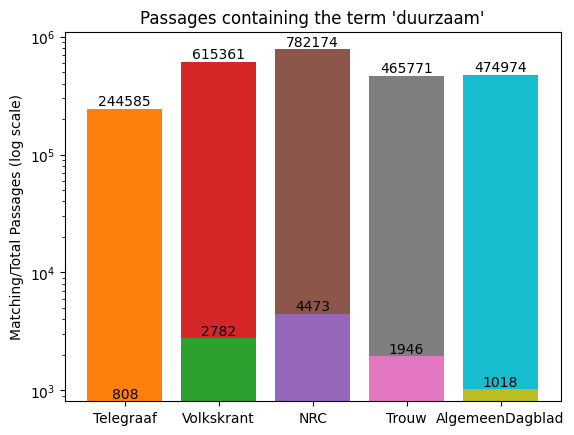

In [180]:
import matplotlib.pyplot as plt

assert text_widget.value.strip(), "No search term provided"

fig, ax = plt.subplots()

ax.set_title(f"Passages containing the term '{text_widget.value}'")

scale = "log"
ax.set_ylabel(f"Matching/Total Passages ({scale} scale)")
ax.set_yscale(scale)

for collection in collection_selector.value:
    doc_freq = db.doc_frequency(
        text_widget.value, collection, metadata_not=metadata_not
    )
    total_count = db.doc_frequency("", collection, metadata_not=metadata_not)

    bar_matches = ax.bar(collection, doc_freq, label=f"{collection} - Matches")
    ax.bar_label(bar_matches, fmt="%d", label_type="edge")

    bar_total = ax.bar(
        collection,
        total_count - doc_freq,
        bottom=doc_freq,
        label=f"{collection} - Total",
    )
    ax.bar_label(bar_total, fmt="%d", label_type="edge")

# Frequencies Per Year

In [181]:
start = 1850
end = 2024

year_range = widgets.SelectionRangeSlider(
    options=[str(i) for i in range(start, end)], index=(100, 150), description="Years"
)
year_range

SelectionRangeSlider(description='Years', index=(100, 150), options=('1850', '1851', '1852', '1853', '1854', '…

In [182]:
normalize = widgets.Checkbox(
    value=True, description="Normalize Frequencies", disabled=False
)
normalize

Checkbox(value=True, description='Normalize Frequencies')

In [183]:
import pandas as pd
from tqdm import tqdm

doc_freqs = pd.DataFrame(
    index=range(int(year_range.value[0]), int(year_range.value[1]))
)

for collection in tqdm(collection_selector.value, unit="collection"):
    doc_freqs[collection] = [
        db.doc_frequency(
            text_widget.value,
            collection,
            {"year": str(year)},
            metadata_not=metadata_not,
            normalize=normalize.value,
        )
        for year in doc_freqs.index
    ]

100%|██████████| 5/5 [00:25<00:00,  5.10s/collection]


<Axes: title={'center': "Normalized Frequency of 'duurzaam' (Rolling Average over 5 years)"}, xlabel='Year', ylabel='Normalized Frequency'>

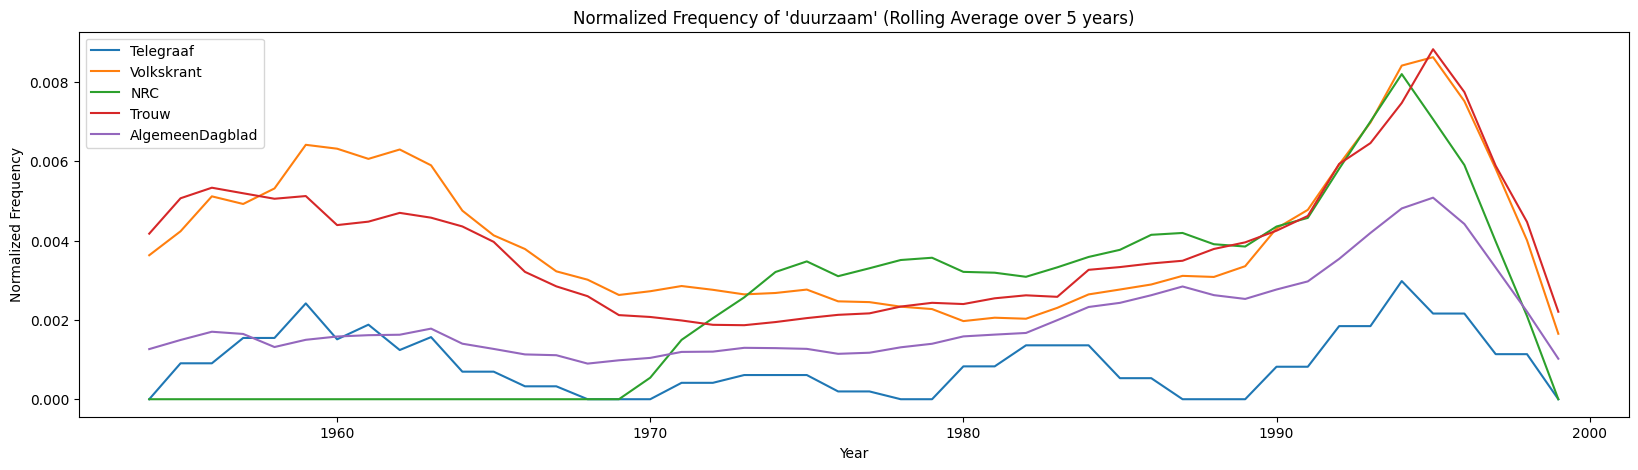

In [184]:
window_size = 5
_prefix = "Normalized " if normalize.value else ""

doc_freqs.rolling(window_size).mean().plot(
    figsize=(20, 5),
    title=f"{_prefix}Frequency of '{text_widget.value}' (Rolling Average over {window_size} years)",
    xlabel="Year",
    ylabel=f"{_prefix}Frequency",
)

# Create Corpus

In [185]:
%autoreload now

In [186]:
collections = [
    db.get_corpus(
        collection,
        [text_widget.value],
        year_from=year_range.value[0],
        year_to=year_range.value[1],
        include_embeddings=True,
        metadata_not=metadata_not,
    )
    for collection in collection_selector.value
]

## Expand Corpus with Close Passages

In [187]:
distance_widget = widgets.FloatSlider(
    value=0.4, min=0, max=1, step=0.01, description="Distance Threshold"
)

distance_widget

FloatSlider(value=0.4, description='Distance Threshold', max=1.0, step=0.01)

In [188]:
from tempo_embeddings.text.corpus import Corpus
from tempo_embeddings.text.passage import Passage
from tempo_embeddings.text.year_span import YearSpan

all_passages: set[Passage] = {
    passage for corpus in collections for passage in corpus.passages
}

neighbours: dict[Corpus, Corpus] = {
    collection: db.neighbours(
        collection,
        k=len(collection),  # at most, double the collection
        collections=collection_selector.value,
        distance=distance_widget.value,
        year_span=YearSpan(year_range.value[0], year_range.value[1]),
        metadata_not=metadata_not,
        exclude_passages=all_passages,
    )
    for collection in tqdm(collections, unit="collection", desc="Getting Neighbours")
}

Getting Neighbours: 100%|██████████| 5/5 [00:09<00:00,  2.00s/collection]


In [189]:
label_length: int = max(len(collection.label) for collection in collections)

print(
    f"{'Collection Label'.ljust(label_length)}\tSize\tNeighbours with Distance < {distance_widget.value}"
)
for collection in collections:
    print(
        f"{collection.label.ljust(label_length)}\t{len(collection)}\t{len(neighbours[collection])}"
    )

Collection Label         	Size	Neighbours with Distance < 0.4
Telegraaf: duurzaam      	461	32
Volkskrant: duurzaam     	2189	158
NRC: duurzaam            	1894	159
Trouw: duurzaam          	1859	172
AlgemeenDagblad: duurzaam	1018	47


## Cluster Corpus

In [190]:
%autoreload now

In [191]:
from tempo_embeddings.text.corpus import Corpus

corpus = sum(collections + list(neighbours.values()), Corpus())

In [192]:
if all(
    (
        passage.metadata["provenance"].startswith("NRC_")
        for passage in corpus.passages
        if "newspaper" not in passage.metadata
    )
):
    fillna_newspaper = "NRC"
else:
    # This happens if we combine newspapers and non-newspapers here
    raise RuntimeError(
        "Cannot determine how to fill empty 'newspaper' metadata fields."
    )

In [193]:
corpus.compress_embeddings()

array([[ 7.85791492,  4.12552929],
       [ 7.38138723,  4.24932528],
       [ 8.35043049,  2.58401942],
       ...,
       [11.74478531, -0.69001126],
       [ 9.74737549,  5.55260849],
       [11.73718357,  2.14828444]])

In [194]:
clusters = list(
    corpus.cluster(
        use_2d_embeddings=True,
        max_clusters=50,
        cluster_selection_method="leaf",
        min_cluster_size=20,
        min_samples=5,
    )
)
len(clusters)

49

In [195]:
from tempo_embeddings.settings import STOPWORDS

for cluster in clusters:
    cluster.set_topic_label(exclude_words=STOPWORDS | {text_widget.value})

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Text(0.5, 1.0, "Cluster Sizes for 'duurzaam'")

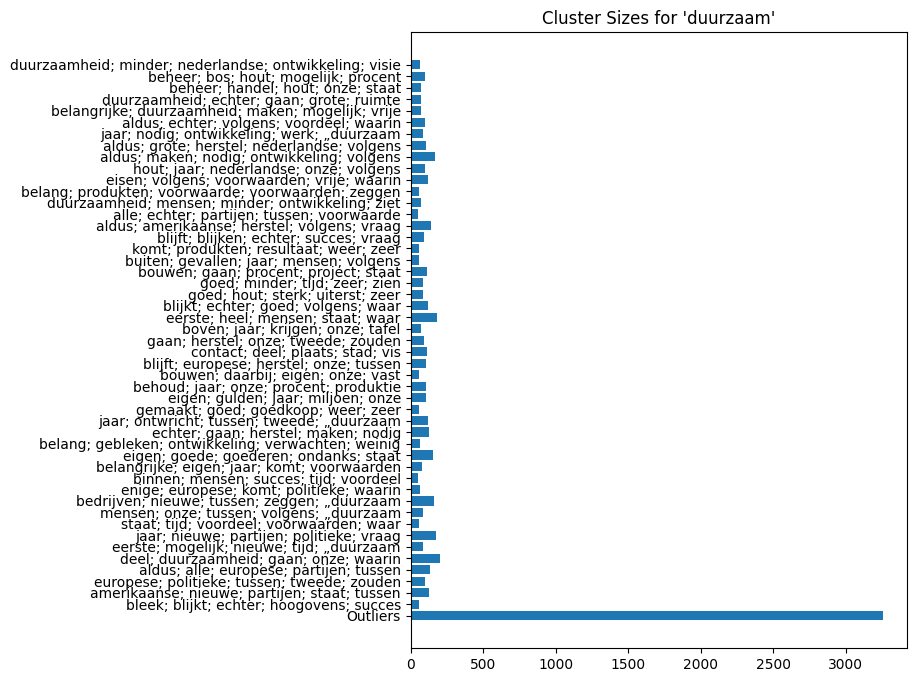

In [196]:
fig, ax = plt.subplots()
fig.set_figheight(len(clusters) // 6)

ax.barh(
    [cluster.label for cluster in clusters],
    [len(cluster) for cluster in clusters],
)
ax.set_title(f"Cluster Sizes for '{text_widget.value}'")

In [197]:
import os

from bokeh.io import output_notebook
from bokeh.plotting import show

from tempo_embeddings.visualization.bokeh import BokehInteractiveVisualizer

try:
    del visualizer
except NameError:
    pass

corpora = clusters + list(neighbours.values())
visualizer = BokehInteractiveVisualizer(*corpora, width=1500, height=500)

os.environ["BOKEH_ALLOW_WS_ORIGIN"] = "*"

output_notebook()

show(visualizer.create_document)

Loading BokehJS ...

# Cluster-based Statistics

In [198]:
import random

cluster_selector = widgets.Select(
    options=[cluster.label for cluster in clusters],
    value=random.choice(clusters).label,
    description="Choose a Cluster:",
    rows=len(clusters),
    layout=widgets.Layout(width="auto"),
)
cluster_selector

Select(description='Choose a Cluster:', index=6, layout=Layout(width='auto'), options=('Outliers', 'bleek; bli…

<Axes: title={'center': "Relative frequency of cluster 'eerste; mogelijk; nieuwe; tijd; „duurzaam' by newspaper"}, xlabel='newspaper', ylabel='Sentence Count'>

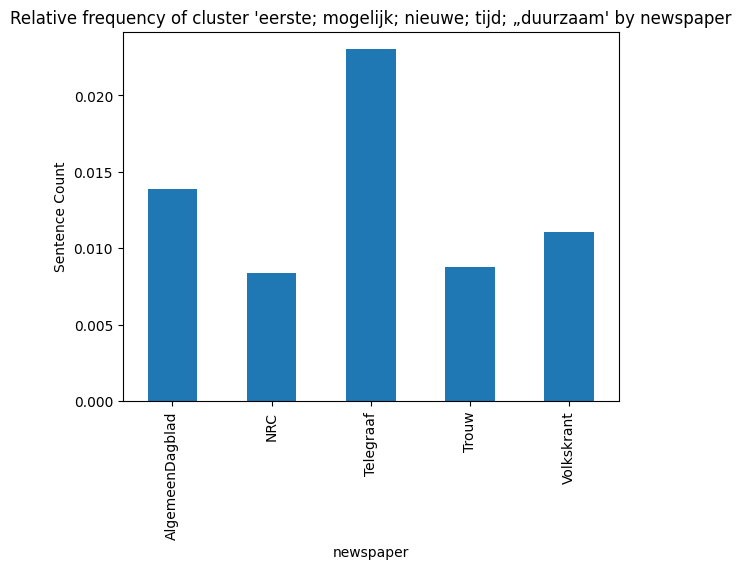

In [199]:
field = "newspaper"

cluster: Corpus = next(
    cluster for cluster in clusters if cluster.label == cluster_selector.value
)

corpus_per_newspaper = pd.Series(
    corpus.get_metadatas(field, default_value=fillna_newspaper)
).value_counts()

cluster_per_newspaper = pd.Series(
    cluster.get_metadatas(field, default_value=fillna_newspaper)
).value_counts()

(cluster_per_newspaper / corpus_per_newspaper).sort_index().plot(
    kind="bar",
    title=f"Relative frequency of cluster '{cluster_selector.value}' by {field}",
    xlabel=field,
    ylabel="Sentence Count",
)

In [200]:
field = "year"

corpus_per_year = pd.Series(
    corpus.get_metadatas(field, default_value=None)
).value_counts()

<Axes: title={'center': "Ccluster 'eerste; mogelijk; nieuwe; tijd; „duurzaam' (Rolling average over 5 years)"}, xlabel='year', ylabel='Sentence Count'>

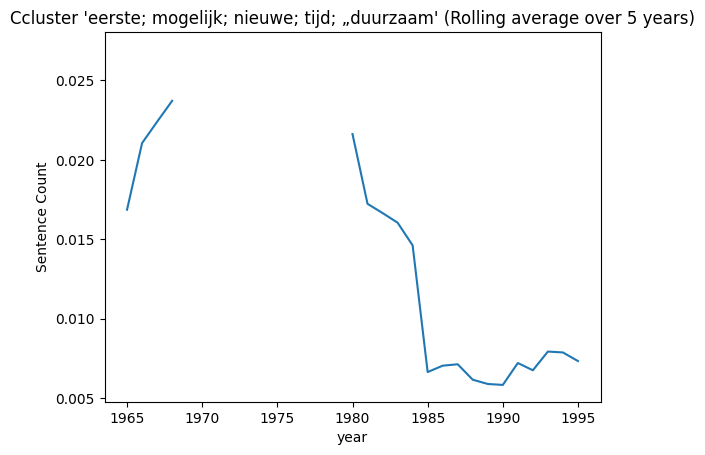

In [201]:
cluster_per_year = pd.Series(
    cluster.get_metadatas(field, default_value=None)
).value_counts()

(cluster_per_year / corpus_per_year).sort_index().rolling(window_size).mean().plot(
    title=f"Ccluster '{cluster_selector.value}' (Rolling average over {window_size} years)",
    xlabel=field,
    ylabel="Sentence Count",
)

In [202]:
from tempo_embeddings.settings import OUTLIERS_LABEL

clusters_per_year = []
for cluster in clusters:
    if cluster.label not in {-1, OUTLIERS_LABEL}:
        s = (
            pd.Series(cluster.get_metadatas(field, default_value=None)).value_counts()
            / corpus_per_year
        )
        s.name = cluster.label
        clusters_per_year.append(s)

clusters_per_year = pd.concat(clusters_per_year, axis=1)

<Axes: title={'center': 'Yearly Distribution of Clusters'}>

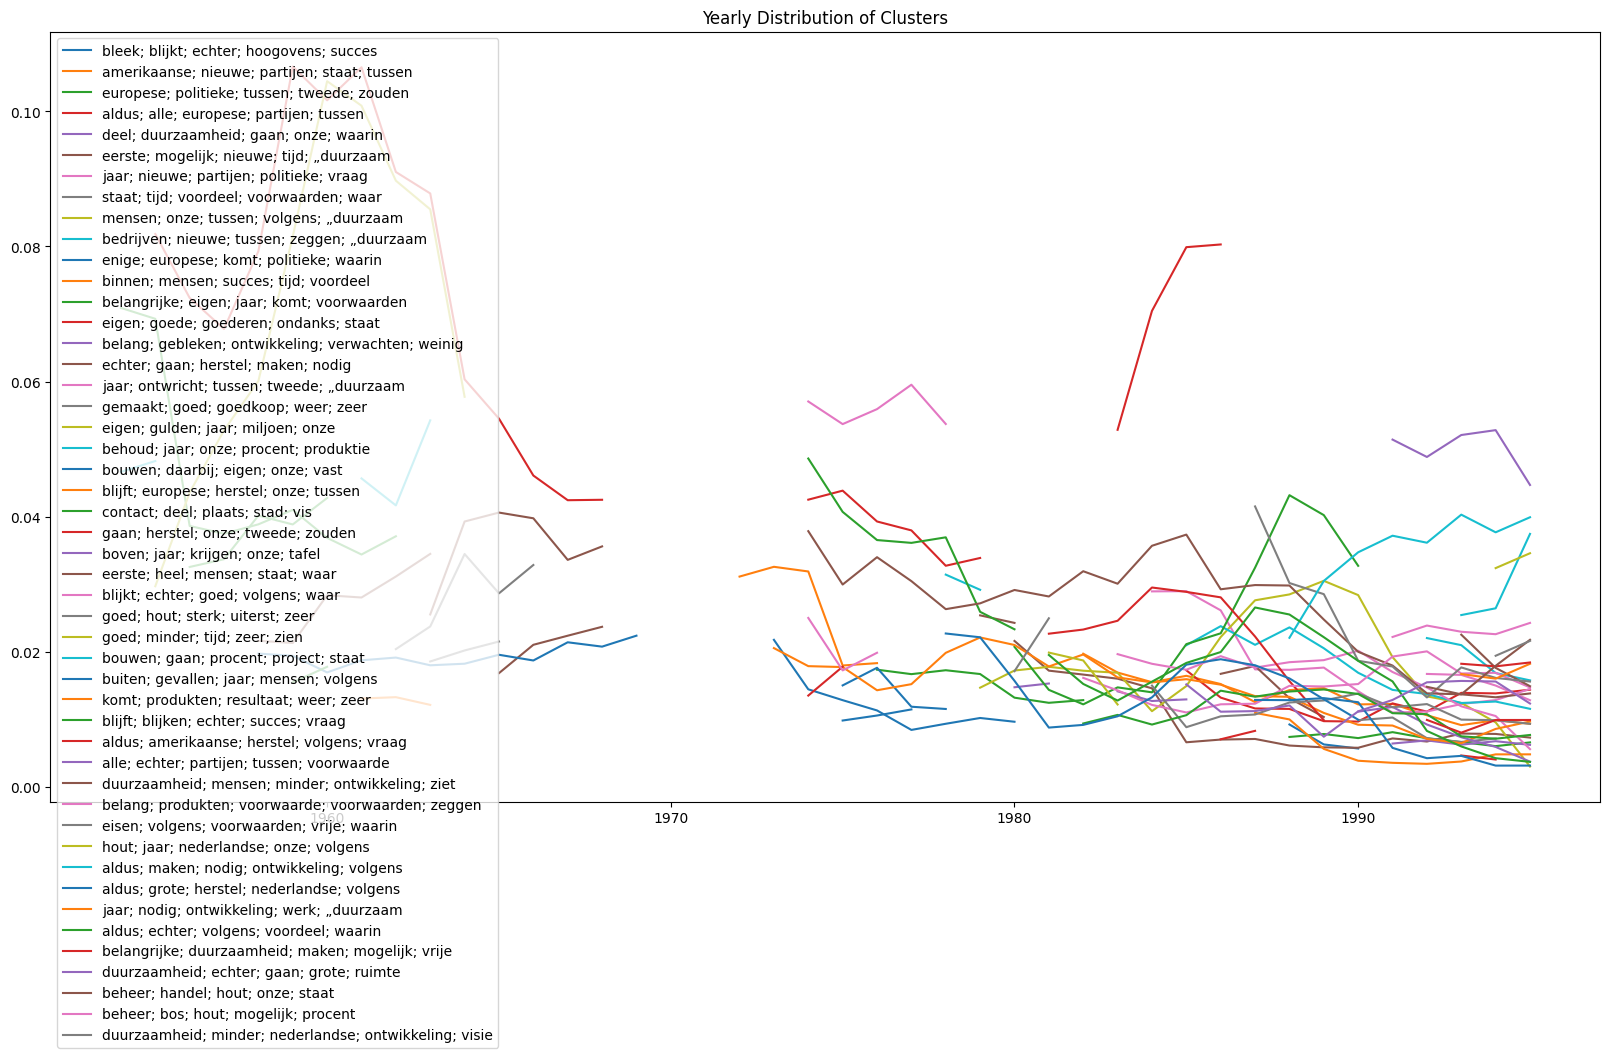

In [203]:
clusters_per_year.sort_index().rolling(window_size).mean().plot(
    kind="line", figsize=(20, 10), title="Yearly Distribution of Clusters"
)